# Practical: Classification

Herman Kamper, 2023

## Preliminaries

In [4]:
%matplotlib inline
from scipy.spatial import distance
from sklearn import datasets, linear_model, neighbors, preprocessing
import matplotlib.pyplot as plt
import numpy as np

## 1. Logistic regression

In this section, you will build a logistic regression model to predict whether a student is admitted to a university or not. Suppose that you are the administrator of the university and you have to determine each applicant's chance of admission based on their results on two exams. You have historical data from previous applicants that you can use as training data. For each training example, you have the applicant’s scores on the two exams and the admissions decision. Your task is to build a classifier that estimates an applicant’s probability of admission based the scores from these two exams.

### 1.1. Pre-process and visualise the data

**Questions:**

- Load the data from `admissions.csv`.
- Plot the data, distinguishing the students who were admitted from those who were not.
- Normalise the data to have zero mean and unit standard deviation. You can use `(X - X.mean(axis=0))/X.std(axis=0)`. Why would we do this?
- Let us assume that the first 80 lines are students that were admitted/not admitted in the past (our training data), that the next 10 lines are data we can use for validation, and that the last 10 lines are data that we want to use for final testing. Split the data accordingly.
- Plot the normalised training set, again distinguishing the students who were admitted from those who were not.

In [5]:
# If you haven't downloaded the data already with the notebook: Download data
import urllib
urllib.request.urlretrieve(
    "https://raw.githubusercontent.com/kamperh/data414/main/practicals/classification/admissions.csv",
    "admissions.csv"
    )

('admissions.csv', <http.client.HTTPMessage at 0x78c4e93f5a50>)

In [6]:

# Answer: Add code and new cells here
import pandas as pd
# Load the dataset
data = pd.read_csv("admissions.csv")
data.head()
print(data.columns)

Index(['# exam1', 'exam2', 'admitted'], dtype='object')


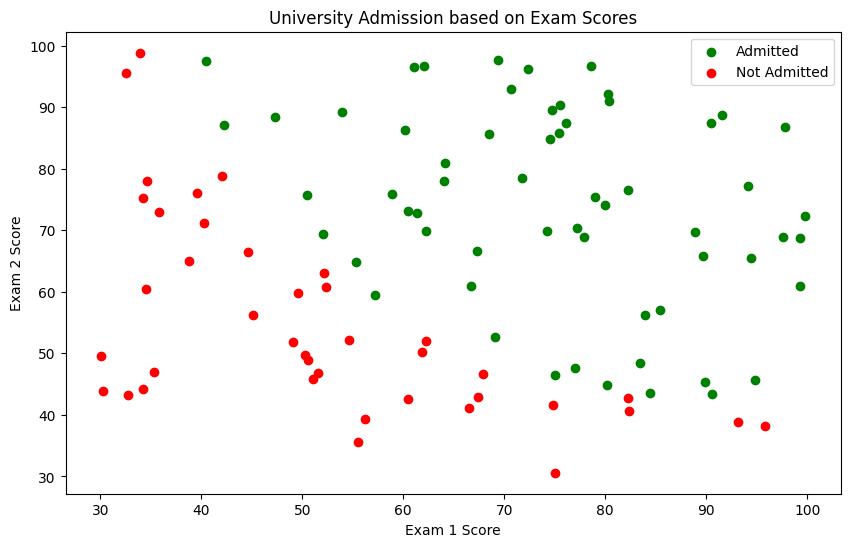

In [7]:
# Separate data based on 'admitted' column
# Rename the column
data.rename(columns={'# exam1': 'exam1'}, inplace=True)

admitted = data[data['admitted'] == 1]
not_admitted = data[data['admitted'] == 0]

# Plot
plt.figure(figsize=(10, 6))
plt.scatter(admitted['exam1'], admitted['exam2'], color='green', label='Admitted')
plt.scatter(not_admitted['exam1'], not_admitted['exam2'], color='red', label='Not Admitted')
plt.xlabel('Exam 1 Score')
plt.ylabel('Exam 2 Score')
plt.legend()
plt.title('University Admission based on Exam Scores')
plt.show()

In [8]:
# Extract features and normalize
X = data[["exam1", "exam2"]].values
X_normalized = (X - X.mean(axis=0)) / X.std(axis=0)

Normalizing the data helps in speeding up the training process and can lead to a better performance because most of the machine learning algorithms work better when features are on a relatively similar scale.

In [9]:
y = data["admitted"].values

# Splitting the data
X_train, y_train = X_normalized[:80], y[:80]
X_val, y_val = X_normalized[80:90], y[80:90]
X_test, y_test = X_normalized[90:], y[90:]

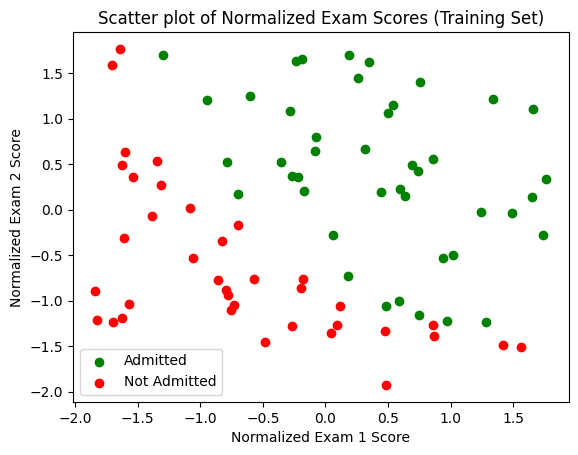

In [10]:
plt.scatter(X_train[y_train == 1][:, 0], X_train[y_train == 1][:, 1], label="Admitted", color="green")
plt.scatter(X_train[y_train == 0][:, 0], X_train[y_train == 0][:, 1], label="Not Admitted", color="red")
plt.xlabel("Normalized Exam 1 Score")
plt.ylabel("Normalized Exam 2 Score")
plt.legend()
plt.title("Scatter plot of Normalized Exam Scores (Training Set)")
plt.show()

### 1.2. Implement logistic regression

For logistic regression, we use the following prediction function:

$$f(\mathbf{x}; \mathbf{w}) = \sigma(\mathbf{w}^\top\mathbf{x}) = \frac{1}{1+e^{-\mathbf{w}^\top\mathbf{x}}}$$

Assuming we have binary labels $y \in \{ 0, 1 \}$, we interpret this function as $f(\mathbf{x}; \mathbf{w}) = P(y=1 \,|\, \mathbf{x}; \mathbf{w})$. We fit it using maximum likelihood estimation, specifically by minising the negative log likelihood:

$$J(\mathbf{w}) = - \sum_{n = 1}^N \left[ y^{(n)}\log f(\mathbf{x}^{(n)}; \mathbf{w}) +  (1 - y^{(n)})\log(1 - f(\mathbf{x}^{(n)}; \mathbf{w})) \right]$$

One way to optimise this loss is by using gradient descent:

$$\mathbf{w} \leftarrow \mathbf{w} - \eta \frac{\partial J (\mathbf{w})}{\partial \mathbf{w}}$$

In this case, the gradient is given by

$$\frac{\partial J (\mathbf{w})}{\partial \mathbf{w}} = - \sum_{n=1}^N (y^{(n)} - f(\mathbf{x}^{(n)}; \mathbf{w})) \mathbf{x}^{(n)}$$

**Questions:**

- Complete the code below to calculate the negative log likelihood for a given dataset.
- Complete the code below to perform logistic regression on he admissions data.

In [82]:
# Answer: Complete the `get_loss` function

# Add bias terms
X_train_bias = np.c_[np.ones((X_train.shape[0], 1)), X_train]
X_val_bias = np.c_[np.ones((X_val.shape[0], 1)), X_val]
X_test_bias = np.c_[np.ones((X_test.shape[0], 1)), X_test]

# Function for calculating NLL
sigmoid = lambda x: 1./(1. + np.exp(-x))
def get_nll_loss(X, y, w):
    loss = 0.0
    for i in range(X.shape[0]):
        xi = X[i]
        yi = y[i]
        z = np.dot(xi, w)
        sigmoid_z = sigmoid(z)
        loss -= (yi * np.log(sigmoid_z) + (1 - yi) * np.log(1 - sigmoid_z))
    return loss/ X.shape[0]

# Calculate NLL for random weights
w = np.random.randn(X_train_bias.shape[1])
loss = get_nll_loss(X_train_bias, y_train, w)
print("NLL for random weights: {:.4f}".format(loss))

NLL for random weights: 1.8167


In [87]:
# Answer: Add the gradient calculation below

# Training parameters
n_iterations = 20
learning_rate = 0.5

# Gradient descent
w = np.random.randn(X_train_bias.shape[1])  # initialise weights
for iteration in range(n_iterations):
    gradients = 0

    for i in range(X_train_bias.shape[0]):
        xi = X_train_bias[i]
        yi = y_train[i]
        z = np.dot(xi, w)
        sigmoid_z = sigmoid(z)
        gradient = (sigmoid_z - yi) * xi  # Gradient for one training example
        gradients += gradient  # Accumulate gradients for all training examples

    gradients /= X_train_bias.shape[0]  # Average gradients over all examples

    w = w - learning_rate*gradients
    train_loss = get_nll_loss(X_train_bias, y_train, w)
    val_loss = get_nll_loss(X_val_bias, y_val, w)
    print(
        "Epoch {:2d}: training loss {:.2f}, validation loss {:.2f}".format(
        iteration, train_loss, val_loss)
        )

Epoch  0: training loss 0.68, validation loss 0.80
Epoch  1: training loss 0.62, validation loss 0.71
Epoch  2: training loss 0.57, validation loss 0.64
Epoch  3: training loss 0.53, validation loss 0.58
Epoch  4: training loss 0.50, validation loss 0.54
Epoch  5: training loss 0.47, validation loss 0.50
Epoch  6: training loss 0.45, validation loss 0.47
Epoch  7: training loss 0.43, validation loss 0.45
Epoch  8: training loss 0.41, validation loss 0.43
Epoch  9: training loss 0.40, validation loss 0.41
Epoch 10: training loss 0.38, validation loss 0.40
Epoch 11: training loss 0.37, validation loss 0.39
Epoch 12: training loss 0.36, validation loss 0.37
Epoch 13: training loss 0.35, validation loss 0.37
Epoch 14: training loss 0.35, validation loss 0.36
Epoch 15: training loss 0.34, validation loss 0.35
Epoch 16: training loss 0.33, validation loss 0.34
Epoch 17: training loss 0.33, validation loss 0.34
Epoch 18: training loss 0.32, validation loss 0.33
Epoch 19: training loss 0.32, v

### 1.3. Plot the decision boundary and make predictions

**Question:** Plot the resulting decision boundary on top of the training data.  
*Hint:* The decision boundary is where $w_0 + w_1x_1 + w_2x_2 = 0$. Write this equation as $y = mx + c$ (with $x$ and $y$ now indicating the plot axes).

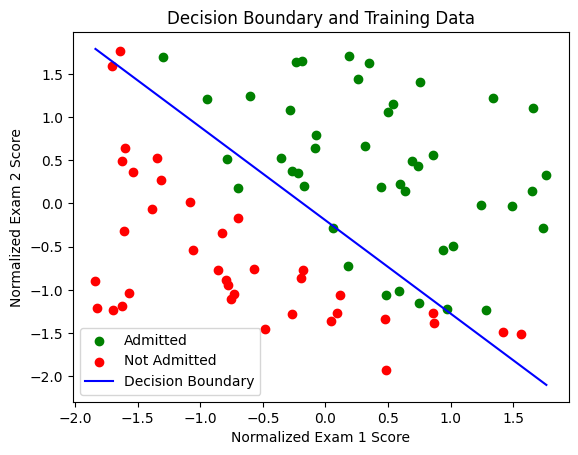

In [88]:

# Answer: Add code and new cells here
# Calculate the decision boundary
x1_boundary = np.linspace(min(X_train_bias[:, 1]), max(X_train_bias[:, 1]), 100)
x2_boundary = -(w[0] + w[1] * x1_boundary) / w[2]

# Plot the training data points
plt.scatter(X_train_bias[y_train == 1][:, 1], X_train_bias[y_train == 1][:, 2], label="Admitted", color="green")
plt.scatter(X_train_bias[y_train == 0][:, 1], X_train_bias[y_train == 0][:, 2], label="Not Admitted", color="red")

# Plot the decision boundary
plt.plot(x1_boundary, x2_boundary, label="Decision Boundary", color="blue")

plt.xlabel("Normalized Exam 1 Score")
plt.ylabel("Normalized Exam 2 Score")
plt.legend()
plt.title("Decision Boundary and Training Data")
plt.show()

**Questions:**

- Calculate the validation accuracy.
- You can go back and change the number of training iterations and learning rate. Note how this affects the validation accuracy and try to find values that give consistent performance.
- Only once you have decided on the final values for these hyperparameters, can you apply your model to the test set. Calculate the test accuracy for your final model.

In [89]:
# Answer: Add code and new cells here
# Calculate predicted probabilities for the validation set
predicted_probabilities = sigmoid(X_val_bias.dot(w))

# Convert probabilities to binary predictions
threshold = 0.5
predicted_labels = (predicted_probabilities >= threshold).astype(int)

# Calculate validation accuracy
validation_accuracy = np.mean(predicted_labels == y_val)
print("Validation Accuracy: {:.2f}%".format(validation_accuracy * 100))

Validation Accuracy: 90.00%


Number of Training Iterations: 20
Learning Rate: 0.5
We have our best hyperparameters,
Validation Accuracy: 90.00% so that we can apply the model to the test set and calculate the test accuracy

In [91]:
# Initialize weights
w = np.random.randn(X_train_bias.shape[1])

# Perform gradient descent with the best hyperparameters
num_iterations, learning_rate = best_hyperparameters

for iteration in range(num_iterations):
    gradients = np.zeros(w.shape)

    for i in range(X_train_bias.shape[0]):
        xi = X_train_bias[i]
        yi = y_train[i]
        z = np.dot(xi, w)
        sigmoid_z = sigmoid(z)
        gradient = xi * (sigmoid_z - yi)
        gradients += gradient

    w -= learning_rate * gradients / X_train_bias.shape[0]

# Calculate test accuracy
threshold = 0.5
predicted_probabilities = sigmoid(X_test_bias.dot(w))
predicted_labels = (predicted_probabilities >= threshold).astype(int)
test_accuracy = np.mean(predicted_labels == y_test)

print("Test Accuracy: {:.2f}%".format(test_accuracy * 100))

Test Accuracy: 90.00%


**Optional question:** You can go back to the start of Section 2.1 and repeat the entire exercise directly on the unnormalised data. Although the scales of the $x_1$ and $x_2$ features are similar, you will observe that the scales of $w_0$, $w_1$ and $w_2$ are actually very different now, making the algorithm much more sensitive to the initialisation of $\mathbf{w}$ since the same learning rate $\eta$ is used for all three weights. With a bit of effort, you could still get it to work, but you will probably have to initialise $\mathbf{w}$ very carefully (maybe try an initial $\mathbf{w} = \begin{bmatrix} -50 & 0 & 0 \end{bmatrix}^\top$ and use a very small learning rate such as $\eta = 0.00001$ and play around with these values).

Scikit-learn also has a `LogisticRegression` class in `sklearn.linear_model`, which you can use from this point onwards. This is (probably) a more efficient implementation than your own, includes a number of extensions, and allows for data with more than just two classes. It also provides the option of specifying different optimisation methods from gradient descent, which might be more robust to some of the initialisation and update issues described above.

## 2. Non-linear decision boundaries

During quality assurance in a microchip fabrication plant, each microchip goes through various checks to ensure it functions correctly. Suppose you are the product manager of the factory and you have the results for some microchips on two different quality checks. From these two checks, you would like to determine whether a new microchip should be accepted or rejected. I.e., you have a dataset of check results on past microchips, from which you can build a prediction model.

### 2.1. KNN classification

The code below loads the data from `microchip.csv`, applies KNN classification to the data, and plots the resulting decision boundary.

**Question:** Change the number of nearest neighbours `K` and observe the change in the decision boundary.

In [92]:
# If you haven't downloaded the data already with the notebook: Download data
import urllib
urllib.request.urlretrieve(
    "https://raw.githubusercontent.com/kamperh/data414/main/practicals/classification/microchip.csv",
    "microchip.csv"
    )

('microchip.csv', <http.client.HTTPMessage at 0x78c4e07f00d0>)

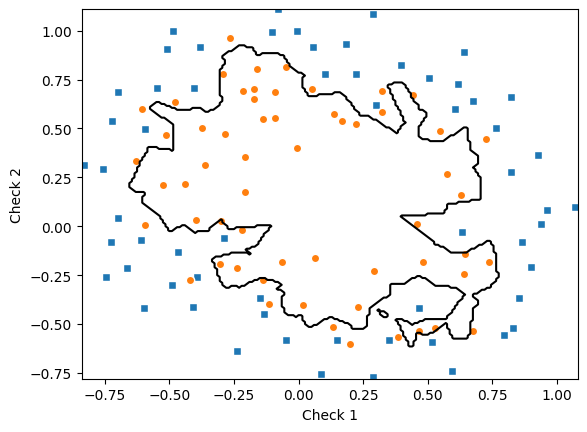

In [93]:
# Load and plot the data
data = np.loadtxt("microchip.csv", delimiter=",")
X = data[:, :2]
y = data[:, 2]
plt.scatter(X[y==0, 0], X[y==0, 1], c="C0", marker="s", edgecolor="white")
plt.scatter(X[y==1, 0], X[y==1, 1], c="C1", marker="o", edgecolor="white")
plt.xlabel("Check 1")
plt.ylabel("Check 2")

# KNN classification
K = 2
knn = neighbors.KNeighborsClassifier(n_neighbors=K)
knn.fit(X, y)

# Create mesh
def make_meshgrid(x, y, h=.01):
    """
    Based on: https://stackoverflow.com/questions/51297423
    """
    x_min, x_max = x.min() - h, x.max() + h
    y_min, y_max = y.min() - h, y.max() + h
    xx, yy = np.meshgrid(np.arange(x_min, x_max, h), np.arange(y_min, y_max, h))
    return xx, yy
X0, X1 = X[:, 0], X[:, 1]  # modify to match your training data
xx, yy = make_meshgrid(X0, X1)
X_new = np.c_[xx.ravel(), yy.ravel()]

# Plot the decision boundary
predictions = knn.predict(X_new).reshape(xx.shape)
plt.contour(xx, yy, predictions, levels=[0.5], linewidths=[1.5], colors=["black"]) #, linestyles=["dashed"])
# plt.tight_layout()



### 2.2. Regularised logistic regression with polynomial features

You will now apply logistic regression to this data using the `LogisticRegression` class from `sklearn.linear_model`.

The loss for regularised logistic regression includes an additional term:

$$J(\mathbf{w}) = - \sum_{n = 1}^N \left[ y^{(n)}\log f(\mathbf{x}^{(n)}; \mathbf{w}) +  (1 - y^{(n)})\log(1 - f(\mathbf{x}^{(n)}; \mathbf{w})) \right] + \lambda \sum_{d = 1}^D w_d^2$$

The $\lambda$ hyperparameter controls the extent of the regularisation. For the `LogisticRegression` class, the `C` argument is proportional to $1/\lambda$, i.e. less regularisation is applied with a large `C`. Regularisation can be turned off by setting `penalty="none"`. Use the `solver="lbfgs"` optimiser in this section.

**Questions:**

- Using scikit-learn classes and functions, apply standard logistic regression to the microchip data and plot the decision boundary.
- Experiment with no regularisation (`penalty="none"`) and with adding more and less regularisation (small and large values for `C`).
- Does regularisation help?

/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py:1173: FutureWarning: `penalty='none'`has been deprecated in 1.2 and will be removed in 1.4. To keep the past behaviour, set `penalty=None`.
  warnings.warn(


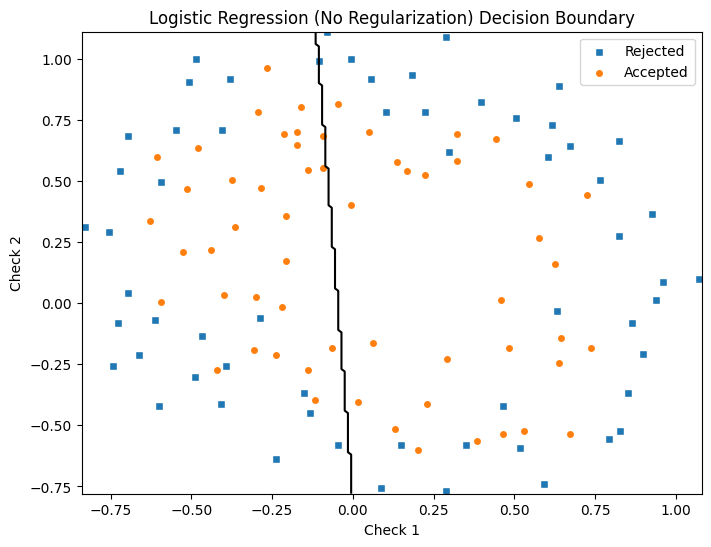

In [94]:

# Answer: Add code and new cells here
from sklearn.linear_model import LogisticRegression

# Create and fit the logistic regression model with no regularization
log_reg_none = LogisticRegression(penalty="none", solver="lbfgs")
log_reg_none.fit(X, y)

# Create a meshgrid for the decision boundary
xx, yy = make_meshgrid(X0, X1)
X_new = np.c_[xx.ravel(), yy.ravel()]

# Predictions on the meshgrid
predictions_none = log_reg_none.predict(X_new).reshape(xx.shape)

# Plot the data points and decision boundary
plt.figure(figsize=(8, 6))
plt.scatter(X[y == 0, 0], X[y == 0, 1], c="C0", marker="s", edgecolor="white", label="Rejected")
plt.scatter(X[y == 1, 0], X[y == 1, 1], c="C1", marker="o", edgecolor="white", label="Accepted")
plt.xlabel("Check 1")
plt.ylabel("Check 2")
plt.contour(xx, yy, predictions_none, levels=[0.5], linewidths=[1.5], colors=["black"])
plt.legend()
plt.title("Logistic Regression (No Regularization) Decision Boundary")
plt.show()


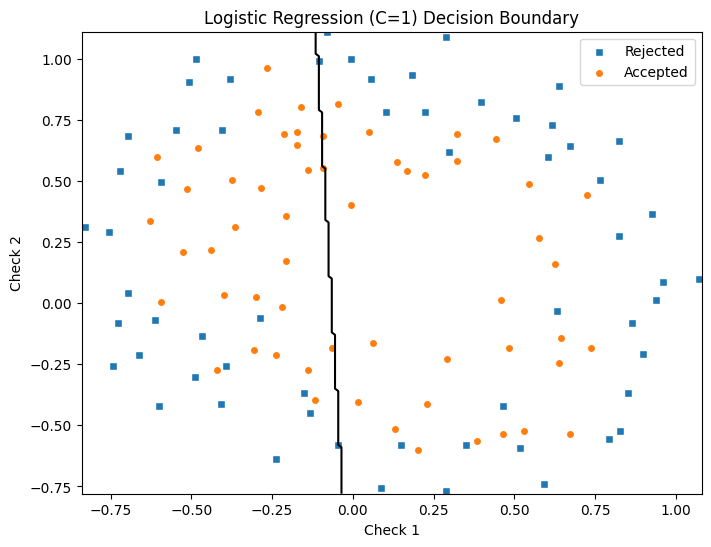

In [99]:
# Create and fit the logistic regression model with C=1
log_reg_c1 = LogisticRegression(C= 1, solver="lbfgs")
log_reg_c1.fit(X, y)

# Predictions on the meshgrid
predictions_c1 = log_reg_c1.predict(X_new).reshape(xx.shape)

# Plot the data points and decision boundary
plt.figure(figsize=(8, 6))
plt.scatter(X[y == 0, 0], X[y == 0, 1], c="C0", marker="s", edgecolor="white", label="Rejected")
plt.scatter(X[y == 1, 0], X[y == 1, 1], c="C1", marker="o", edgecolor="white", label="Accepted")
plt.xlabel("Check 1")
plt.ylabel("Check 2")
plt.contour(xx, yy, predictions_c1, levels=[0.5], linewidths=[1.5], colors=["black"])
plt.legend()
plt.title("Logistic Regression (C=1) Decision Boundary")
plt.show()

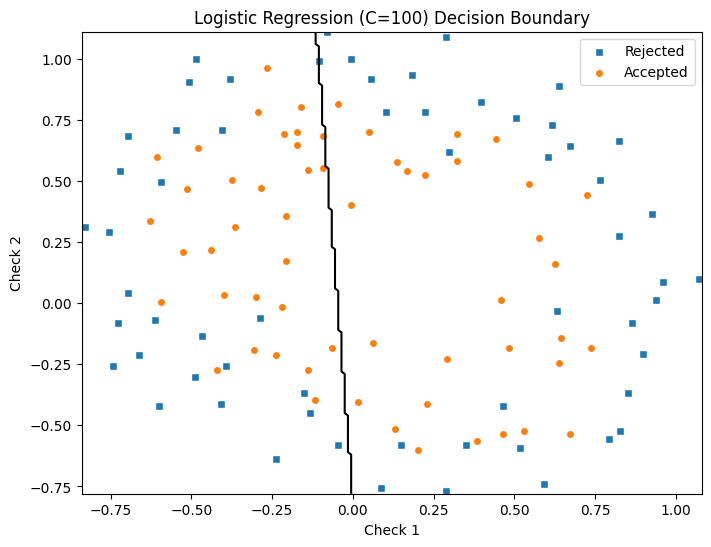

In [100]:
# Create and fit the logistic regression model with C=100
log_reg_c100 = LogisticRegression(C=100, solver="lbfgs")
log_reg_c100.fit(X, y)

# Predictions on the meshgrid
predictions_c100 = log_reg_c100.predict(X_new).reshape(xx.shape)

# Plot the data points and decision boundary
plt.figure(figsize=(8, 6))
plt.scatter(X[y == 0, 0], X[y == 0, 1], c="C0", marker="s", edgecolor="white", label="Rejected")
plt.scatter(X[y == 1, 0], X[y == 1, 1], c="C1", marker="o", edgecolor="white", label="Accepted")
plt.xlabel("Check 1")
plt.ylabel("Check 2")
plt.contour(xx, yy, predictions_c100, levels=[0.5], linewidths=[1.5], colors=["black"])
plt.legend()
plt.title("Logistic Regression (C=100) Decision Boundary")
plt.show()

no help

You will now use the `PolynomialFeatures` class from `sklearn.preprocessing` to fit a logistic regression model with $6^{\text{th}}$ order polynomial features, i.e.,

$$\boldsymbol{\phi}(\mathbf{x}) = \begin{bmatrix} 1 & x_1 & x_2 & x_1^2 & x_1x_2 & x_2^2 & x_1^3 & \ldots & x_1x_2^5 & x_2^6 \end{bmatrix}^\top$$

**Questions:**

- First fit the logistic regression models without any regularisation, and plot the decision boundary.
- Add some regularisation, and plot the decision boundary again.
- Increase regularisation (small `C`, e.g. `0.01`) and observe the effect.

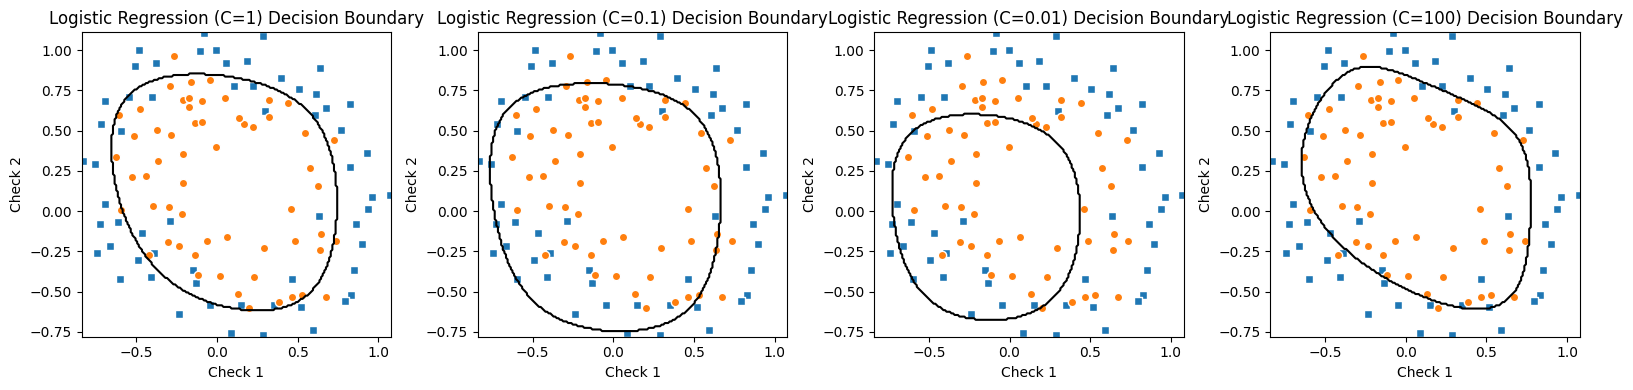

In [102]:

# Answer: Add code and new cells here
from sklearn.preprocessing import PolynomialFeatures
from sklearn.pipeline import make_pipeline

# Create polynomial features with degree 6
poly_features = PolynomialFeatures(degree=6)
X_poly = poly_features.fit_transform(X)

# Fit logistic regression models with different levels of regularization
C_values = [1, 0.1, 0.01, 100]

plt.figure(figsize=(16, 4))

for i, C in enumerate(C_values):
    # Create a logistic regression model with specified C (inverse of regularization strength)
    log_reg_poly = LogisticRegression(C=C, solver="lbfgs", max_iter=10000)

    # Fit the model to the polynomial features
    log_reg_poly.fit(X_poly, y)

    # Predictions on the meshgrid
    predictions_poly = log_reg_poly.predict(poly_features.transform(X_new)).reshape(xx.shape)

    # Plot the data points and decision boundary
    plt.subplot(1, len(C_values), i + 1)
    plt.scatter(X[y == 0, 0], X[y == 0, 1], c="C0", marker="s", edgecolor="white", label="Rejected")
    plt.scatter(X[y == 1, 0], X[y == 1, 1], c="C1", marker="o", edgecolor="white", label="Accepted")
    plt.xlabel("Check 1")
    plt.ylabel("Check 2")
    plt.contour(xx, yy, predictions_poly, levels=[0.5], linewidths=[1.5], colors=["black"])
    plt.title(f"Logistic Regression (C={C}) Decision Boundary")

plt.tight_layout()
plt.show()

## Acknowledgements
- Sections 1 and 2 are based on examples from the [Coursera Machine Learning](https://www.coursera.org/learn/machine-learning) course.